# Blackbox Optimization with NN driven model

In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
# https://docs.scipy.org/doc/scipy/tutorial/optimize.html#broyden-fletcher-goldfarb-shanno-algorithm-method-bfgs
import scipy.optimize as optimize
from sklearn.metrics import mean_squared_error

# Using ipynb import functions defined in other nb
sys.path.append("myfun/")
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_models import *
from ipynb.fs.defs.myfun_plot import *

2023-09-06 10:22:45.758037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


# Step 1: Synthetic data

## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post')

In [3]:
# For sake of simplicity conseder only a scene
df = dflist[0] # sequence
scn = df.T[2]  # scene

In [4]:
# Useful params
N = scn['N. vehicles']
tstamps = scn['Tarr']

## Create the model NN

In [5]:
DOE =[[1,2,1]] #Design of experiment

model = create_model(DOE[0])
# model.summary()

## Evaluate the NN in each time interval

In [6]:
# parameters to set
v0 = 30
LEARNING_RATE_NN = 0.0001
LEARNING_RATE_v0=0.5
NUM_ITER=500
PLOT_ITER=250

            - Time interval n.0: [72.44, 72.64]
                * y_true: [25.85001228 31.10049693]
                * v_ann: [21.428508758544922, 32.14969253540039, 28.25129782284649]

----------------------------------------------------------------------------------------------------
            - Time interval n.1: [72.64, 72.84]
                * y_true: [30.00006309 33.82077482]
                * v_ann: [22.514827728271484, 32.47018051147461, 28.25129782284649]

----------------------------------------------------------------------------------------------------
            - Time interval n.2: [72.84, 73.04]
                * y_true: [23.75011307 26.19081077]
                * v_ann: [23.89568328857422, 30.62496566772461, 28.25129782284649]

----------------------------------------------------------------------------------------------------
            - Time interval n.3: [73.04, 73.24]
                * y_true: [29.90025591 27.11111625]
                * v_ann: [23.85483360290527

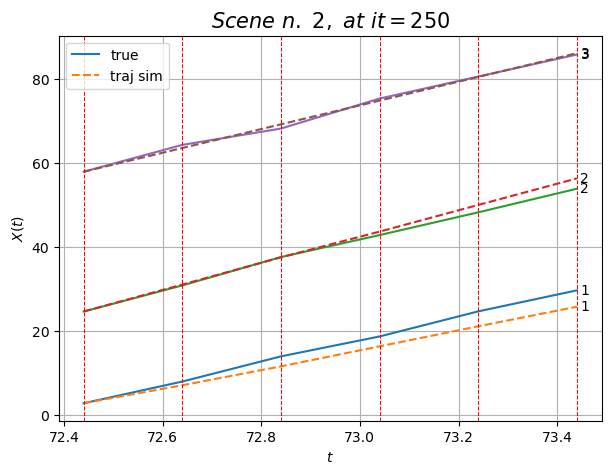

            - Time interval n.0: [72.44, 72.64]
                * y_true: [25.85001228 31.10049693]
                * v_ann: [21.579940795898438, 32.28996658325195, 28.250920573908388]

----------------------------------------------------------------------------------------------------
            - Time interval n.1: [72.64, 72.84]
                * y_true: [30.00006309 33.82077482]
                * v_ann: [22.608928680419922, 32.5283203125, 28.250920573908388]

----------------------------------------------------------------------------------------------------
            - Time interval n.2: [72.84, 73.04]
                * y_true: [23.75011307 26.19081077]
                * v_ann: [23.718894958496094, 30.346708297729492, 28.250920573908388]

----------------------------------------------------------------------------------------------------
            - Time interval n.3: [73.04, 73.24]
                * y_true: [29.90025591 27.11111625]
                * v_ann: [23.9005851745605

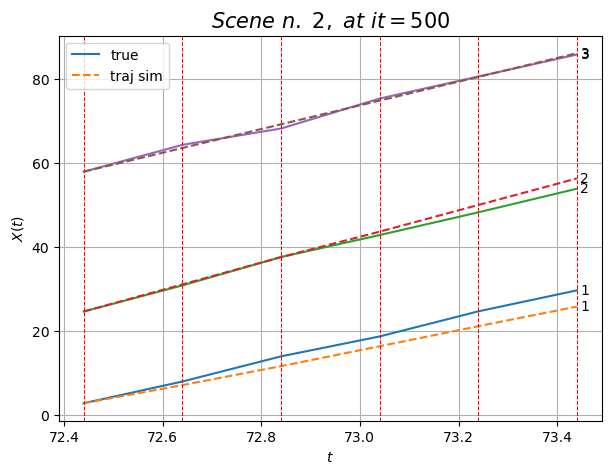

In [7]:
t_list, x_list, v_list, _ = solve_nn_scn_custom(model, scn, v0,
                                                LEARNING_RATE_NN, LEARNING_RATE_v0,
                                                NUM_ITER, PLOT_ITER)

## Create synthetic data

In [8]:
# Take samples from the simulation
Nt = len(t_list)  # timestamps original dataset
M = 5                # Number of samples
Mt = int(Nt/M)       # timestamp to take equispaced samples

idx = list(range(0,Nt,1+Mt))    # indexes to extract
tshat, Xhat = np.array(t_list)[idx], [traj[idx] for traj in np.array(x_list)]

In [9]:
idx

[0, 5, 10, 15, 20]

## Plot

In [10]:
# Params for the plot
trajs = [scn['Xarr'], np.array(x_list)]
labels_plot = ["true","nn sim"]
title = f"Trajs simulated by NN driven LWR model"

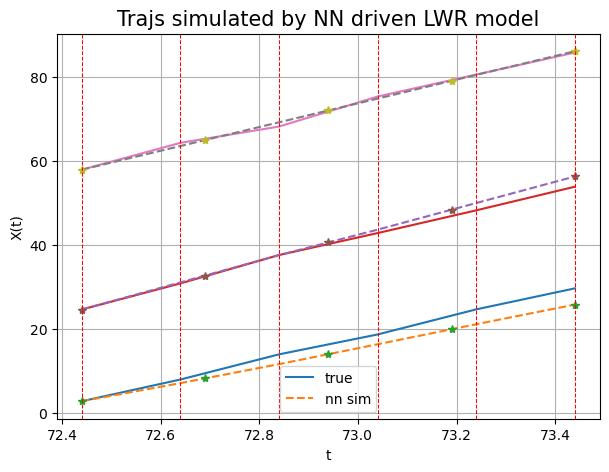

In [11]:
# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    ax.plot(tstamps, scn['Xarr'][veh])
    ax.plot(t_list, x_list[veh], '--')
    ax.plot(tshat, Xhat[veh], '*')

for ts in tstamps:
    ax.axvline(x = ts, color = 'red', linestyle = '--', linewidth=0.75)
    
# Annotate the name of each variable at the last value
plot_annotation(ax, scn, trajs, scale=1.004)

ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(title, fontsize=15)
# Limits for the plot
#plot_limits(ax, scn, trajs, xbal=0.01, ybal=0.05)
plt.legend(labels_plot)
plt.grid()
plt.show()

# Step 2: Optimization with blackbox approach

In [12]:
# definition with freezed parameteres regarding the scene.
def f_wrapped(v0):
    t_list, x_list, _, _ = solve_nn_scn_custom(model, scn, v0,
                                                LEARNING_RATE_NN, LEARNING_RATE_v0,
                                                NUM_ITER = 250, PLOT_ITER = 999)
    return x_list

In [13]:
def loss_fun(v0):
    "Loss function"
    
    X = f_wrapped(v0)
    Xupd = [traj[idx] for traj in np.array(X)] # extracting the same index as in X
        
    mse = mean_squared_error(Xhat, Xupd)

    return mse

In [14]:
# using the parameters used in the creation of synthetic data the loss must be 0!
mse = loss_fun(v0)

In [15]:
mse

0.00044944021975055007

In [16]:
# initial_guess = [30]

# #result = optimize.minimize(loss_fun, initial_guess, method="Nelder-Mead", tol = 1e0, options={'maxiter':3})
# result = optimize.minimize(loss_fun, initial_guess, method="Powell", tol = 10000)
# if result.success:
#     fitted_params = result.x
#     print(fitted_params)
# else:
#     raise ValueError(result.message)

In [17]:
# fitted_params

In [18]:
# result.message